In [10]:
import numpy as np 
import gym
import ray
import ray.rllib.agents.ppo as ppo
from ray import tune
import pandas as pd
import GPUtil

from gym import Env, spaces

pd.options.display.max_rows = 12

#get a matrix of distances between locations
df = pd.read_csv('dist_vologda_matrix.csv', sep=',')
df = df.iloc[:, 1:]

#some parameters
working_hours = 12
truck_speed = 60

df = df / 1000
df

,АЗС №35400 Кичменгский Городок,АЗС №35401 Великий Устюг-1,АЗС №35402 Великий Устюг-2,АЗС №35403 Дунай,АЗС №35404 Нюксеница,АЗС №35405 Борисово-Судское,АЗС №35406 Журавлево,АЗС №35407 Грязовец-1,АЗС №35408 Грязовец-2,АЗС №35409 Савино,...,АЗС №35454 Октябрьский пр.-1 (Вологда),АЗС №35455 Октябрьский пр.-2 (Вологда),АЗС №35456 Маяковская,АЗС №35457 Краснодонцев,АЗС №35458 Северсталь,АЗС №35459 Олимпийская,АЗС №35460 Северное шоссе-1,АЗС №35461 Северное шоссе-2,АЗС № 35462 Аксеново,Нефтебаза
0,0.0000,99.2272,101.8513,139.2135,154.2522,777.2635,102.4328,520.5020,517.8863,266.7014,...,610.3886,610.3028,607.3283,609.0579,611.0852,611.0605,604.2684,605.7555,502.9826,477.9325
1,99.0684,0.0000,4.9465,134.5201,149.5589,748.0318,5.5280,491.2703,488.6546,241.7276,...,581.1570,581.0711,578.0967,579.8263,581.8535,581.8288,575.0368,576.5238,473.7510,448.7008
2,101.8148,5.0688,0.0000,137.2665,152.3053,750.7781,3.0302,494.0166,491.4010,244.4739,...,583.9033,583.8174,580.8430,582.5726,584.5999,584.5752,577.7831,579.2702,476.4973,451.4472
3,139.2135,134.6791,137.3031,0.0000,15.0961,613.5690,137.8846,356.8075,354.1918,107.2648,...,446.6942,446.6083,443.6339,445.3635,447.3908,447.3660,440.5740,442.0610,339.2882,314.2380
4,154.2522,149.7178,152.3419,15.0961,0.0000,613.8947,152.9234,357.1332,354.5176,107.5905,...,447.0199,446.9341,443.9596,445.6892,447.7165,447.6918,440.8997,442.3868,339.6139,314.5638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,611.7861,582.6174,585.2414,447.9957,448.3214,191.2351,585.8229,181.8523,179.2367,345.2112,...,10.1276,10.0417,7.2967,3.3719,10.8241,0.0000,6.1623,4.6720,107.2118,142.1894
60,605.7962,576.6275,579.2515,442.0057,442.3315,185.0682,579.8330,175.8624,173.2467,339.2213,...,6.8726,6.7867,3.8122,4.8070,7.5691,6.8095,0.0000,1.5045,101.2218,136.1995
61,607.1467,577.9779,580.6020,443.3562,443.6820,186.4186,581.1835,177.2129,174.5972,340.5717,...,8.2230,8.1372,5.1627,3.5396,8.9196,5.5422,1.5229,0.0000,102.5723,137.5500
62,504.6641,475.4954,478.1194,340.8736,341.1994,274.3706,478.7009,74.7303,72.1146,238.0892,...,107.4957,107.4099,104.4354,106.1650,108.1923,108.1676,101.3755,102.8626,0.0000,35.0674


In [11]:
#remove locations, which cannot be served in 12 hours (driver can't get there and come back in 12 hours)
to_remove = ((2 * (df.values[-1,:] / truck_speed) < working_hours) == False).nonzero()[0]
df = df.drop(df.index[to_remove])
df = df.drop(df.columns[to_remove], axis=1)
df = df.reset_index(drop=True)
df

,АЗС №35403 Дунай,АЗС №35404 Нюксеница,АЗС №35405 Борисово-Судское,АЗС №35407 Грязовец-1,АЗС №35408 Грязовец-2,АЗС №35409 Савино,АЗС №35410 Сазоново-1,АЗС №35411 Сазоново-2,АЗС №35412 Вытегра,АЗС №35413 Липник,...,АЗС №35454 Октябрьский пр.-1 (Вологда),АЗС №35455 Октябрьский пр.-2 (Вологда),АЗС №35456 Маяковская,АЗС №35457 Краснодонцев,АЗС №35458 Северсталь,АЗС №35459 Олимпийская,АЗС №35460 Северное шоссе-1,АЗС №35461 Северное шоссе-2,АЗС № 35462 Аксеново,Нефтебаза
0,0.0000,15.0961,613.5690,356.8075,354.1918,107.2648,619.0077,618.5201,629.3182,472.6696,...,446.6942,446.6083,443.6339,445.3635,447.3908,447.3660,440.5740,442.0610,339.2882,314.2380
1,15.0961,0.0000,613.8947,357.1332,354.5176,107.5905,619.3335,618.8458,629.6440,472.9954,...,447.0199,446.9341,443.9596,445.6892,447.7165,447.6918,440.8997,442.3868,339.6139,314.5638
2,615.1980,615.5238,0.0000,349.0547,346.4390,512.4135,142.9597,142.4720,165.8965,193.2966,...,187.4480,187.3622,184.7850,188.3816,183.6881,191.1772,185.1426,186.6296,274.4141,309.3918
3,356.1259,356.4516,349.7479,0.0000,3.7018,253.3414,355.1867,354.6990,373.5276,216.8790,...,182.8731,182.7873,179.8128,181.5424,183.5697,183.5450,176.7529,178.2400,75.4671,45.6714
4,353.5507,353.8764,347.1727,3.7422,0.0000,250.7662,352.6115,352.1238,370.9524,214.3038,...,180.2979,180.2120,177.2376,178.9672,180.9945,180.9698,174.1777,175.6648,72.8919,43.0962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,447.9957,448.3214,191.2351,181.8523,179.2367,345.2112,196.6738,196.1861,332.9386,176.2900,...,10.1276,10.0417,7.2967,3.3719,10.8241,0.0000,6.1623,4.6720,107.2118,142.1894
52,442.0057,442.3315,185.0682,175.8624,173.2467,339.2213,190.5069,190.0192,326.9487,170.3001,...,6.8726,6.7867,3.8122,4.8070,7.5691,6.8095,0.0000,1.5045,101.2218,136.1995
53,443.3562,443.6820,186.4186,177.2129,174.5972,340.5717,191.8574,191.3697,328.2991,171.6506,...,8.2230,8.1372,5.1627,3.5396,8.9196,5.5422,1.5229,0.0000,102.5723,137.5500
54,340.8736,341.1994,274.3706,74.7303,72.1146,238.0892,279.8093,279.3216,346.5072,189.8586,...,107.4957,107.4099,104.4354,106.1650,108.1923,108.1676,101.3755,102.8626,0.0000,35.0674


In [12]:
from numpy.random import default_rng

#shrink array
#df = df.iloc[40:56,40:56]
rng = default_rng()
idx = rng.choice(len(df.values[0])-1, size=len(df.values[0]) - 1 - 15, replace=False)
print(idx)
df = df.drop(df.index[idx])
df = df.drop(df.columns[idx], axis=1)
df = df.reset_index(drop=True)
N = len(df.values[0])
print(N)
df

[49 16 30 44 17 23 27 50 42 15 31 13 22 28 40 47  5 37 14 39  2 12 51 18
  7  9  6 43 46 45 29 36 11 48 41 33 35 38 10 32]
16


,АЗС №35403 Дунай,АЗС №35404 Нюксеница,АЗС №35407 Грязовец-1,АЗС №35408 Грязовец-2,АЗС №35412 Вытегра,АЗС №35426 Сямжа,АЗС №35427 Марьинское,АЗС №35429 Чекшино-1,АЗС №35432 Ботово,АЗС №35433 Сокол,АЗС №35434 Верховажье,АЗС №35442 Гагарина (Вологда),АЗС №35460 Северное шоссе-1,АЗС №35461 Северное шоссе-2,АЗС № 35462 Аксеново,Нефтебаза
0,0.0000,15.0961,356.8075,354.1918,629.3182,292.0560,308.4985,244.6727,424.0409,289.5149,158.1086,314.6216,440.5740,442.0610,339.2882,314.2380
1,15.0961,0.0000,357.1332,354.5176,629.6440,292.3817,308.8242,244.9984,424.3666,289.8406,158.4343,314.9473,440.8997,442.3868,339.6139,314.5638
2,356.1259,356.4516,0.0000,3.7018,373.5276,160.0557,58.6155,111.6199,160.2198,82.2330,268.5268,46.0720,176.7529,178.2400,75.4671,45.6714
3,353.5507,353.8764,3.7422,0.0000,370.9524,157.4805,56.0403,109.0447,157.6446,79.6577,265.9516,43.4967,174.1777,175.6648,72.8919,43.0962
4,630.8056,631.1314,373.2181,370.6024,0.0000,434.7354,321.5271,386.2996,311.7056,356.9127,543.2065,326.3433,326.0666,327.5537,345.1153,329.7586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,314.6857,315.0115,46.6465,44.0309,325.6432,118.6156,10.7312,70.1797,112.5491,40.7928,227.0867,0.0000,129.0822,130.5692,27.7964,9.1032
12,442.0057,442.3315,175.8624,173.2467,326.9487,245.9356,132.7272,197.4997,17.0854,168.1128,354.4067,128.7692,0.0000,1.5045,101.2218,136.1995
13,443.3562,443.6820,177.2129,174.5972,328.2991,247.2860,134.0777,198.8502,18.4358,169.4633,355.7571,130.1197,1.5229,0.0000,102.5723,137.5500
14,340.8736,341.1994,74.7303,72.1146,346.5072,144.8035,31.5951,96.3676,84.8425,66.9807,253.2746,27.6371,101.3755,102.8626,0.0000,35.0674


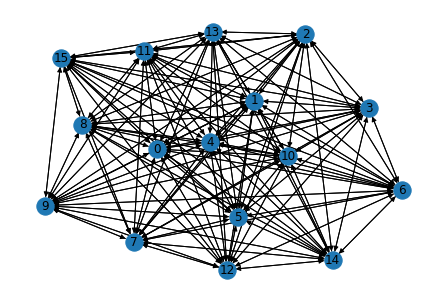

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_numpy_matrix(df.values, create_using=nx.DiGraph)
nx.draw(G, with_labels = True)
plt.show()

In [14]:
#custom gym environment for our problem
m = 5
N = len(df.values[0])
working_hours = 12
truck_speed = 60

class TransportScape(Env):
    def __init__(self, env_config):
        self.num_of_trucks = m
        self.num_of_locations = N
        self.h = working_hours #working hours of each truck driver
        self.speed = truck_speed
        self.distances = df.values #an array, containing distances between locations
    
        self.action_space = spaces.MultiDiscrete([self.num_of_trucks, self.num_of_locations - 1])
    
        self.observation_space = spaces.Dict(
        {
            #x_i - shows each truck's location
            'truck location': spaces.MultiDiscrete(np.full(self.num_of_trucks, self.num_of_locations)),
            #p_j - shows whether a truck is assigned to this particular location or not
            'assignment': spaces.MultiBinary(self.num_of_locations - 1), 
            #u_i - shows whether a particular truck was used before
            'truck usage': spaces.MultiBinary(self.num_of_trucks),
            #delta_i - shows how much time each truck has left until the end of the work day
            'time left': spaces.Box(low=np.zeros(self.num_of_trucks), high=np.full(self.num_of_trucks, self.h), dtype=np.float64)
        })
        self.reset()
        
    def nice_print(self):
        print("Truck Location")
        print(self.state['truck location'])
        print("Assignment")
        print(self.state['assignment'])
        print("Truck Usage")
        print(self.state['truck usage'])
        print("Time Left")
        print(self.state['time left'])
        
    def reset(self):
        self.state = {'truck location': np.full(self.num_of_trucks, self.num_of_locations - 1),
                      'assignment': np.zeros(self.num_of_locations - 1),
                      'truck usage': np.zeros(self.num_of_trucks),
                      'time left': np.full(self.num_of_trucks, self.h)}
        self.done = False
        return self.state 
    
    def step(self, action):
        i, j = action[0], action[1]
        truck_loc = self.state['truck location']
        assignment = self.state['assignment']
        truck_use = self.state['truck usage']
        time_left = self.state['time left']
        
        #if a truck is already assigned to this location - penalty
        if assignment[j] == 1:
            self.reward = -6000
        #if no time left - penalty
        elif (time_left[i] - self.distances[truck_loc[i], j] / self.speed - self.distances[j, -1] / self.speed) < 0:
            self.reward = -6000
        #else - assign truck to a new location
        else:
            self.reward = 0
            #print("else")
            #if needs to use an unused before truck - penalty
            if truck_use[i] == 0:
                self.reward = -2000
                truck_use[i] = 1
            assignment[j] = 1
            self.reward -= self.distances[truck_loc[i], j]
            time_left[i] -= self.distances[truck_loc[i], j] / self.speed - 0.5
            truck_loc[i] = j
        #if all locations have trucks assigned to them - end episode
        if np.all(assignment == 1):
            self.done = True
        else:
            self.done = False
        
        self.state['truck location'] = truck_loc
        self.state['assignment'] = assignment
        self.state['truck usage'] = truck_use
        self.state['time left'] = time_left
        
        return self.state, self.reward, self.done, {}

In [15]:
config = ppo.DEFAULT_CONFIG.copy()
config["num_workers"] = 8
config["framework"] = "torch"
#config['num_cpus_per_worker'] = 2  # This avoids running out of resources in the notebook environment when this cell is re-executed
config['kl_coeff'] = 0.0 #можно поменять
config["log_level"] = "ERROR"
config["env_config"] = {}
config["clip_param"] = 0.3
config["entropy_coeff"] = 0.01
config['lr'] = 0.0001
config["horizon"] = N #numbers of t_steps after which termiate
config["train_batch_size"] = 4000 
config["rollout_fragment_length"] = 500 # batch_size per worker

In [16]:
ray.shutdown()
ray.init()

2022-06-06 15:37:37,053	INFO services.py:1456 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.8.13', ray_version='1.12.0', ray_commit='f18fc31c7562990955556899090f8e8656b48d2d', address_info={'node_ip_address': '192.168.1.76', 'raylet_ip_address': '192.168.1.76', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-06-06_15-37-34_649015_804124/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-06-06_15-37-34_649015_804124/sockets/raylet', 'webui_url': '127.0.0.1:8265', 'session_dir': '/tmp/ray/session_2022-06-06_15-37-34_649015_804124', 'metrics_export_port': 63569, 'gcs_address': '192.168.1.76:53833', 'address': '192.168.1.76:53833', 'node_id': '08c8a0988e68088233824520dd439567d506a9a80152e7f21d5c1c72'})

In [17]:
agent = ppo.PPOTrainer(config=config, env=TransportScape)

In [18]:
import datetime
start = datetime.datetime.now()
print(start)

for i in range(1501):
    result = agent.train()
    if i % 10 == 0:
        print('i: ', i)
        print('mean episode length:', result['episode_len_mean'])
        print('max episode reward:', result['episode_reward_max'])
        print('mean episode reward:', result['episode_reward_mean'])
        print('min episode reward:', result['episode_reward_min'])
        print('total episodes:', result['episodes_total'])
        checkpoint = agent.save()
finish = datetime.datetime.now()
print(finish)
duration = finish - start
print("Total Hours: ", duration.total_seconds() / 3600)

2022-06-06 15:37:47.220420
i:  0
mean episode length: 16.0
max episode reward: -33078.4053
mean episode reward: -53608.45278145161
min episode reward: -71122.1079
total episodes: 248
i:  10
mean episode length: 16.0
max episode reward: -29682.8425
mean episode reward: -48158.48841612903
min episode reward: -70830.6405
total episodes: 2744
i:  20
mean episode length: 16.0
max episode reward: -25101.6477
mean episode reward: -42556.18755282257
min episode reward: -57440.318199999994
total episodes: 5248
i:  30
mean episode length: 16.0
max episode reward: -23912.007200000004
mean episode reward: -39561.186967338705
min episode reward: -53974.4058
total episodes: 7744
i:  40
mean episode length: 16.0
max episode reward: -23555.8785
mean episode reward: -36998.20060524194
min episode reward: -58898.4014
total episodes: 10248
i:  50
mean episode length: 16.0
max episode reward: -23372.2875
mean episode reward: -36269.67527620967
min episode reward: -54911.7387
total episodes: 12744
i:  60
m

i:  470
mean episode length: 15.343629343629344
max episode reward: -11691.130400000002
mean episode reward: -17820.517121621622
min episode reward: -75228.1026
total episodes: 120376
i:  480
mean episode length: 15.267175572519085
max episode reward: -11452.0603
mean episode reward: -17561.452492748092
min episode reward: -63065.6961
total episodes: 122978
i:  490
mean episode length: 15.578125
max episode reward: -11458.679100000001
mean episode reward: -25897.915057031252
min episode reward: -71334.1301
total episodes: 125572
i:  500
mean episode length: 15.298850574712644
max episode reward: -11695.616100000003
mean episode reward: -18739.38382183908
min episode reward: -65730.4176
total episodes: 128178
i:  510
mean episode length: 15.386973180076629
max episode reward: -11556.249699999998
mean episode reward: -17753.277704214564
min episode reward: -70952.78020000001
total episodes: 130784
i:  520
mean episode length: 15.378378378378379
max episode reward: -11574.133800000003
mea

i:  920
mean episode length: 15.221374045801527
max episode reward: -11496.5336
mean episode reward: -16390.77492557252
min episode reward: -76713.5695
total episodes: 237798
i:  930
mean episode length: 15.31800766283525
max episode reward: -11509.8527
mean episode reward: -18041.283538314176
min episode reward: -70920.9497
total episodes: 240416
i:  940
mean episode length: 15.320610687022901
max episode reward: -11695.616100000003
mean episode reward: -18249.834490839694
min episode reward: -70843.08840000001
total episodes: 243025
i:  950
mean episode length: 15.505791505791505
max episode reward: -11577.0469
mean episode reward: -22628.907156370657
min episode reward: -82249.6532
total episodes: 245635
i:  960
mean episode length: 15.242424242424242
max episode reward: -11433.681200000003
mean episode reward: -16360.679676515152
min episode reward: -65344.9616
total episodes: 248254
i:  970
mean episode length: 15.337164750957854
max episode reward: -11455.815099999998
mean episod

i:  1370
mean episode length: 15.182509505703422
max episode reward: -11696.143300000002
mean episode reward: -15470.296492775666
min episode reward: -70868.5021
total episodes: 355480
i:  1380
mean episode length: 15.240458015267176
max episode reward: -11695.988200000002
mean episode reward: -18177.49327137405
min episode reward: -80615.8716
total episodes: 358102
i:  1390
mean episode length: 15.6015625
max episode reward: -11500.298
mean episode reward: -29188.94551328125
min episode reward: -92046.7818
total episodes: 360716
i:  1400
mean episode length: 15.340996168582375
max episode reward: -11640.432099999998
mean episode reward: -18287.685490421456
min episode reward: -71239.8634
total episodes: 363334
i:  1410
mean episode length: 15.209125475285171
max episode reward: -11696.143300000002
mean episode reward: -15858.223133460075
min episode reward: -74670.67180000001
total episodes: 365934
i:  1420
mean episode length: 15.314176245210728
max episode reward: -11584.38519999999

In [19]:
env = TransportScape(config)
state = env.reset()
g = 0
done = False
reward = 0
actions = []
i = 0
while not done:
    action = agent.compute_action(state, explore = False)
    actions.append(action)
    print("action: {:}; reward: {:}".format(action, reward))
    state, reward, done, info = env.step(action)
    g += reward
    i += 1
    if i == 1000:
        break
print("Final state:")
print("Assignment:", state['assignment'])
print("Trucks used:", state['truck usage'])
print("Time left", state['time left'])
print(g) 

action: [4 1]; reward: 0
action: [ 1 11]; reward: -2314.5311
action: [3 4]; reward: -2009.0571
action: [2 0]; reward: -2329.8897
action: [ 0 13]; reward: -2314.2054
action: [ 0 12]; reward: -2138.2363
action: [0 8]; reward: -1.5229000000000001
action: [ 0 14]; reward: -17.0854
action: [0 3]; reward: -86.62589999999999
action: [1 9]; reward: -72.11460000000001
action: [1 7]; reward: -40.7928
action: [ 1 10]; reward: -45.082699999999996
action: [3 6]; reward: -156.9364
action: [4 2]; reward: -321.52709999999996
action: [1 5]; reward: -357.1332
Final state:
Assignment: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Trucks used: [1. 1. 1. 1. 1.]
Time left [8 5 7 2 1]
-12313.317500000001


In [20]:
truck_paths = {}
for k, v in actions:
    truck_paths.setdefault(k,[]).append(v)
for k in truck_paths:
    print("Truck #{:}: {:}".format(k,truck_paths[k]))

Truck #4: [1, 2]
Truck #1: [11, 9, 7, 10, 5]
Truck #3: [4, 6]
Truck #2: [0]
Truck #0: [13, 12, 8, 14, 3]


In [21]:
def GetLength(route):
    length = df.values[-1, route[0]]
    for i in range(1, len(route)):
        length += df.values[route[i-1], route[i]]
    length += df.values[route[-1], -1]
    
    return length

In [22]:
dist = 0
for k in truck_paths:
    dist += GetLength(truck_paths[k])
dist

2850.3100999999997

In [23]:
for k in truck_paths:
    print(GetLength(truck_paths[k]) / truck_speed)

11.955594999999997
7.976894999999999
11.1206
10.474056666666666
5.978021666666666
